In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Display the row's columns and data in dictionary format for Measurement
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x291510cc860>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
# Display the row's columns and data in dictionary format for Measurement
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x291510d9278>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
station_data = session.query(Station.name, Station.station).all()
station_data

[('WAIKIKI 717.2, HI US', 'USC00519397'),
 ('KANEOHE 838.1, HI US', 'USC00513117'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830'),
 ('PEARL CITY, HI US', 'USC00517948'),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523'),
 ('WAIHEE 837.5, HI US', 'USC00519281'),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918'),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128')]

In [13]:
# Calculate the date 1 year ago from today
today_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
today_date

('2017-08-23')

In [14]:
last_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year_date

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores (I chose the staition in Waikiki)
past_one_year_data = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.station == "USC00519397").filter(Measurement.date >= last_year_date).order_by(Measurement.date).all()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
past_one_year_df = pd.DataFrame(past_one_year_data, columns=['Date', 'Precipitation'])
past_one_year_df.set_index('Date', inplace=True)
past_one_year_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


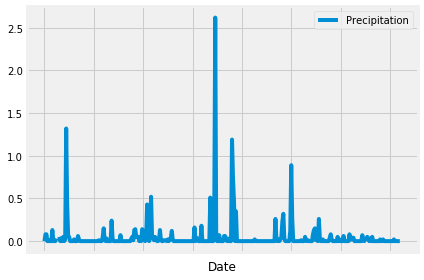

In [17]:
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
past_one_year_df.plot.line()
plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
past_one_year_df.describe()

,Precipitation
count,359.000000
mean,0.044819
std,0.188810
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [19]:
# How many stations are available in this dataset?
number_of_station = session.query(Station.name).group_by(Station.name).count()
number_of_station

9

In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_observation = session.query(Station.station, func.count(Measurement.tobs)).\
filter(Station.station == Measurement.station).group_by(Station.name).order_by(func.count(Measurement.tobs).desc()).all()
station_observation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_tob = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
highest_tob = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
average_tob = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
temp_summary = (lowest_tob, highest_tob, average_tob)  
temp_summary

((54.0), (85.0), (71.66378066378067))

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_history = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == "USC00519281").filter(Measurement.date >= last_year_date).order_by(Measurement.date).all()

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
temp_history_df = pd.DataFrame(temp_history, columns=['Date', 'Tobs'])
temp_history_df.set_index('Date', inplace=True)
temp_history_df.head()

,Tobs
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


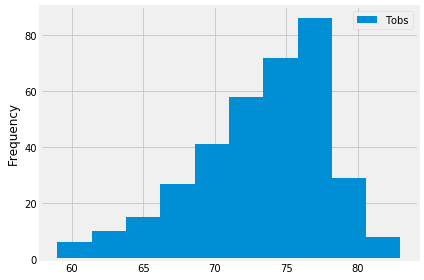

In [24]:
temp_history_df.plot.hist()
plt.tight_layout()
plt.show()

In [25]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


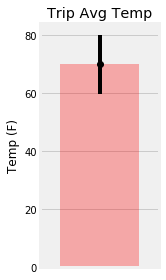

In [27]:
plt.subplot(1, 3, 1)

tav = calc_temps('2016-02-28', '2016-03-05')[0][1]
tmin = calc_temps('2016-02-28', '2016-03-05')[0][0]
tmax = calc_temps('2016-02-28', '2016-03-05')[0][2]


value = [tav]
x_axis = np.arange(len(value))

plt.bar(x_axis, value, color='r', width=1, alpha=0.3, align="center")

plt.errorbar(x_axis, tav, yerr=tmax-tav , fmt="o", color="black", alpha=1)

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(-0.75, len(x_axis)-0.25)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(np.arange(0, tmax+10, 20))
plt.grid(b=None, which='major', axis='x')
plt.tight_layout()
plt.show()

In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.station == Station.station).\
            filter(Measurement.date >= '2012-02-28').filter(Measurement.date <= '2012-03-05').\
                    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  11.08),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  10.32),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.79),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  3.8400000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.92),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.1800000000000002),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.76),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.03),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
datelist= []
start_date = dt.datetime(2016, 2, 28)
end_date = dt.datetime(2016, 3, 5)
date = start_date - dt.timedelta(days=1)

while date < end_date:
    date = date + dt.timedelta(days=1)
    datelist.append(date)

# Stip off the year and save a list of %m-%d strings
datelist_md = [date.strftime("%m-%d") for date in datelist]
datelist_md

['02-28', '02-29', '03-01', '03-02', '03-03', '03-04', '03-05']

In [31]:
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in datelist_md:
    print(daily_normals(date))

[(65.0, 70.65517241379311, 80.0)]
[(67.0, 71.73333333333333, 79.0)]
[(64.0, 70.0327868852459, 76.0)]
[(61.0, 70.36666666666666, 78.0)]
[(60.0, 70.06896551724138, 78.0)]
[(57.0, 69.27272727272727, 77.0)]
[(60.0, 67.89090909090909, 76.0)]


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
master_dic_list = []
for date in datelist_md:
    date_dic = {"Date": date,
               "tmin": daily_normals(date)[0][0],
               "tave": daily_normals(date)[0][1],
               "tmax": daily_normals(date)[0][2],
              }
    master_dic_list.append(date_dic)      

df = pd.DataFrame(master_dic_list)
df = df[["Date", "tmin", "tave", "tmax"]]
df = df.set_index("Date")
df

,tmin,tave,tmax
Date,,,
02-28,65.0,70.655172,80.0
02-29,67.0,71.733333,79.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


In [33]:
datelist_md

['02-28', '02-29', '03-01', '03-02', '03-03', '03-04', '03-05']

In [34]:
x_axis = np.arange(len(datelist_md))
x_axis

array([0, 1, 2, 3, 4, 5, 6])

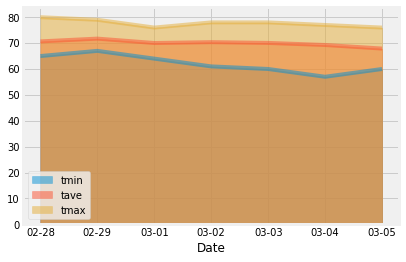

In [35]:
tick_locations = [value for value in x_axis]

df.plot.area(stacked=False)
plt.xticks(tick_locations, datelist_md)
plt.show()